In [112]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

from datafold import (
    EDMD,
    DMDStandard,
    GaussianKernel,
    TSCPolynomialFeatures,
    TSCRadialBasis,
    TSCDataFrame
)
from datafold.utils._systems import Hopf
from datafold.utils.general import generate_2d_regular_mesh

In [113]:
df = pd.read_csv("result_df.csv")
#df = pd.read_csv("result_df.csv", index_col=[0, 1, 2], header=[0])
data = df[df.id==0]

#tscdf = TSCDataFrame.from_csv("result_df.csv")
#tscdf
data = data.drop(["id","run_id"], axis = 'columns')
print(data.shape)
data.max()

(77562, 3)


timeStep                    1251
faceId                        62
meshDensityCounting-PID4      53
dtype: int64

In [114]:
n_timesteps = 1251
time_values=np.linspace(0,500, n_timesteps)
time_values

array([0.000e+00, 4.000e-01, 8.000e-01, ..., 4.992e+02, 4.996e+02,
       5.000e+02])

In [115]:
num_faces=data['faceId'].max()
num_faces

62

In [116]:
dfc= {}
for i in range(1,num_faces+1,1):
    
    row= data.shape[0]
    series1=[[],[]]
    for j in range(0,row):
        if data['faceId'].iloc[j]== i:
            series1[0].append(data['faceId'].iloc[j])
            series1[1].append(data['meshDensityCounting-PID4'].iloc[j])
    dfc[i] = pd.DataFrame({'faceId' : series1[0],
                           'meshDensityCounting-PID4' : series1[1]})

dfc[2].head   

<bound method NDFrame.head of       faceId  meshDensityCounting-PID4
0          2                         0
1          2                         0
2          2                         0
3          2                         0
4          2                         0
...      ...                       ...
1246       2                         0
1247       2                         0
1248       2                         0
1249       2                         0
1250       2                         0

[1251 rows x 2 columns]>

In [117]:
dataframes=[]
for i in range(1,num_faces+1,1):
    dataframes.append(dfc[i]) 

In [118]:
tsc_regular = TSCDataFrame.from_frame_list([dc for dc in dataframes])
tsc_regular

feature  faceId  meshDensityCounting-PID4
ID time                                  
0  0          1                         0
   1          1                         0
   2          1                         0
   3          1                         0
   4          1                         0
...         ...                       ...
61 1246      62                         0
   1247      62                         0
   1248      62                         0
   1249      62                         0
   1250      62                         0

[77562 rows x 2 columns]

In [119]:
tsc_regular.values.T

array([[ 1,  1,  1, ..., 62, 62, 62],
       [ 0,  0,  0, ...,  0,  0,  0]])

<Axes: xlabel='time'>

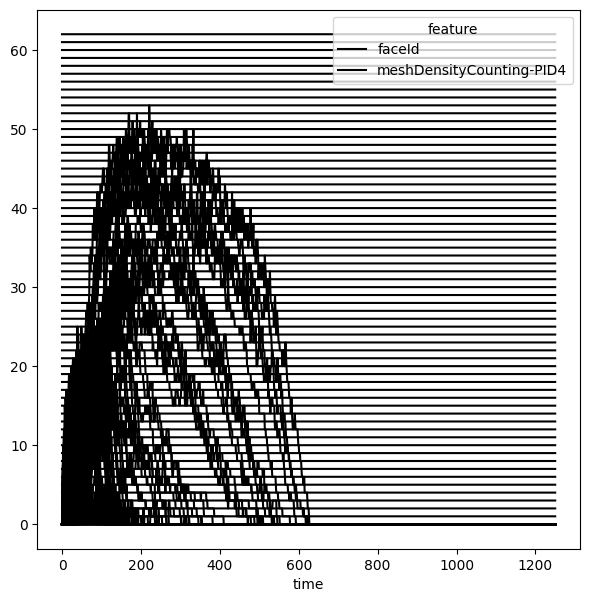

In [120]:
tsc_regular.plot(figsize=(7, 7))

In [135]:
X_tsc=tsc_regular
X_tsc.to_csv('input3.csv', sep='\t')

In [121]:
print(f"time delta: {X_tsc.delta_time}")
print(f"nr. time series: {X_tsc.n_timeseries}")
print(f"nr. timesteps per time series: {X_tsc.n_timesteps}")
print(f"(n_samples, n_features): {X_tsc.shape}")
print(f"time interval {X_tsc.time_interval()}")
print(f"Same time values: {X_tsc.is_same_time_values()}")
print("")
print("Data snippet fo training data:")

time delta: 1
nr. time series: 62
nr. timesteps per time series: 1251
(n_samples, n_features): (77562, 2)
time interval (0, 1250)
Same time values: True

Data snippet fo training data:


In [124]:
X_tsc.initial_states()

/home/uppili11/.local/lib/python3.10/site-packages/datafold/pcfold/timeseries/collection.py:1636: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  return self.groupby(by=TSCDataFrame.tsc_id_idx_name, axis=0, level=0).head(


,feature,faceId,meshDensityCounting-PID4
ID,time,,
0,0,1,0
1,0,2,0
2,0,3,0
3,0,4,0
4,0,5,0
...,...,...,...
57,0,58,0
58,0,59,0
59,0,60,0


In [125]:
X_tsc.time_values()

array([   0,    1,    2, ..., 1248, 1249, 1250])

In [126]:
dmd = DMDStandard().fit(X=X_tsc, store_system_matrix=True)

# Check available attributes
attributes = [attr for attr in dir(dmd) if not callable(getattr(dmd, attr)) and not attr.startswith("__")]
print("Available Attributes:")
print(attributes)

# Print values of some common attributes
if 'dmd_modes' in attributes:
    print("DMD Modes:")
    print(dmd.dmd_modes)

if 'eigenvalues_' in attributes:
    print("Eigenvalues:")
    print(dmd.eigenvalues_)

Available Attributes:
['_abc_impl', '_cls_feature_attrs', '_cls_valid_sys_mode', '_cls_valid_sys_type', '_valid_reconstruct_modes', 'approx_generator', 'compute_pseudospectrum', 'control_matrix_', 'diagonalize', 'dmd_modes', 'dt_', 'eigenvalues_', 'eigenvectors_left_', 'eigenvectors_right_', 'feature_names_in_', 'is_control_affine', 'is_controlled', 'is_differential_system', 'is_flowmap_system', 'is_matrix_mode', 'is_spectral_mode', 'is_time_invariant', 'n_features_in_', 'rank', 'rcond', 'reconstruct_mode', 'residual_filter', 'sys_mode', 'sys_type', 'system_matrix_']
DMD Modes:
[[0.5039994 1.       ]
 [0.863704  0.       ]]
Eigenvalues:
[1. 1.]


In [134]:
dmd = DMDStandard().fit(
    X=X_tsc, store_system_matrix=True
)  # X must be of type TSCDataFrame
dmd_values = dmd.predict(X_tsc.initial_states(), time_values=X_tsc.time_values())

#dmd_values_oos = dmd.predict(X_tsc.iloc[-1, :].to_numpy(), time_values=np.linspace(0, 100, 1250))

print(
    "Data snipped for predicted time series training data and out-of-sample prediction"
)
dmd_values.to_csv('out3.csv', sep='\t')

/home/uppili11/.local/lib/python3.10/site-packages/datafold/pcfold/timeseries/collection.py:1636: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  return self.groupby(by=TSCDataFrame.tsc_id_idx_name, axis=0, level=0).head(
/home/uppili11/.local/lib/python3.10/site-packages/datafold/pcfold/timeseries/collection.py:1666: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  return self.groupby(by=TSCDataFrame.tsc_id_idx_name, axis=0, level=0).tail(


Data snipped for predicted time series training data and out-of-sample prediction


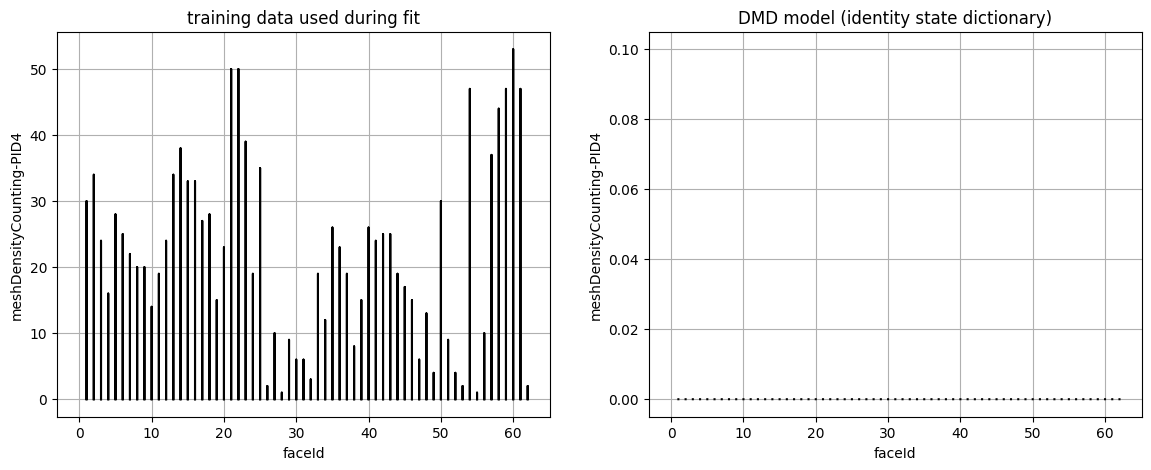

In [128]:
f, ax = plt.subplots(1, 2, figsize=(14, 5))
for _id, df in X_tsc.itertimeseries():
    ax[0].plot(df["faceId"].to_numpy(), df["meshDensityCounting-PID4"].to_numpy(), 0.1, c="black")
    #include_arrow(ax[0], df)

ax[0].set_title("training data used during fit")
ax[0].set_xlabel("faceId")
ax[0].set_ylabel("meshDensityCounting-PID4")
#ax[0].axis("equal")
ax[0].grid()

for _id, df in dmd_values.itertimeseries():
    ax[1].plot(df["faceId"].to_numpy(), df["meshDensityCounting-PID4"].to_numpy(), 0.1, c="black")
    #include_arrow(ax[1], df)

ax[1].set_title("DMD model (identity state dictionary)")
ax[1].set_xlabel("faceId")
ax[1].set_ylabel("meshDensityCounting-PID4")
#ax[1].axis("equal")
ax[1].grid()

In [131]:
#dmd_values_oos = dmd.predict(X_tsc.iloc[-1, :].to_numpy(),time_values=np.linspace(0, 100, 1000))

In [132]:
#dmd_values_oos

'# generate red "out-of-sample" prediction, for extra analysis below\nax[1].plot(\n    dmd_values_oos["faceId"].to_numpy(),\n    dmd_values_oos["meshDensityCounting-PID4"].to_numpy(),\n    0.1,\n    c="red",\n    linewidth=3,\n)\n#include_arrow(ax[1], dmd_values_oos)\n'

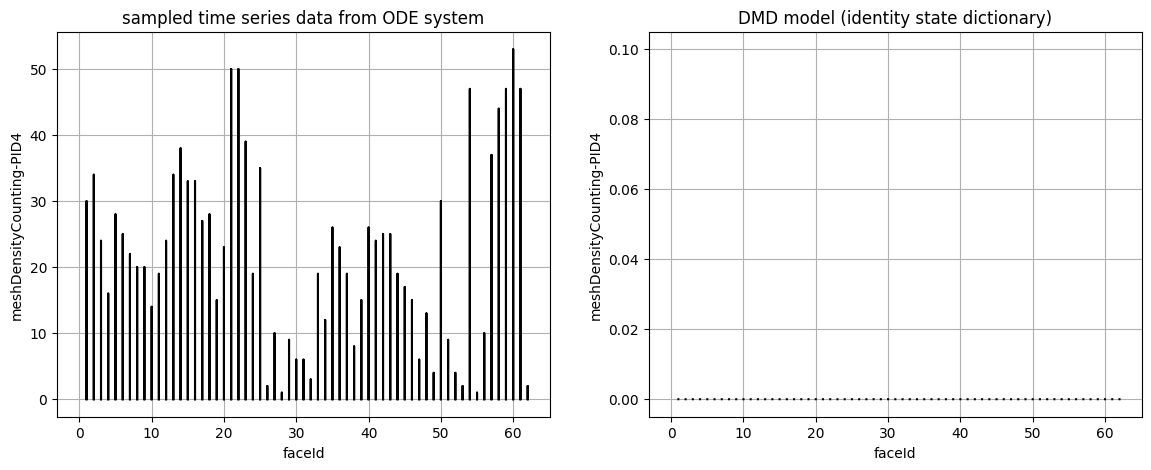

In [133]:
f, ax = plt.subplots(1, 2, figsize=(14, 5))
for _id, df in X_tsc.itertimeseries():
    ax[0].plot(df["faceId"].to_numpy(),df["meshDensityCounting-PID4"].to_numpy(), 0.1, c="black")
    #ax[0].plot(time_values,df["face2"].to_numpy(), 0.1, c="black")
    #include_arrow(ax[0], df)

ax[0].set_title("sampled time series data from ODE system")
ax[0].set_xlabel("faceId")
ax[0].set_ylabel("meshDensityCounting-PID4")
#ax[0].axis("equal")
ax[0].grid();

for _id, df in dmd_values.itertimeseries():
    ax[1].plot(df["faceId"].to_numpy(),df["meshDensityCounting-PID4"].to_numpy(), 0.1, c="black")
    #ax[1].plot(time_values,df["face2"].to_numpy(), 0.1, c="black")
    #include_arrow(ax[1], df)

ax[1].set_title("DMD model (identity state dictionary)")
ax[1].set_xlabel("faceId")
ax[1].set_ylabel("meshDensityCounting-PID4")
#ax[1].axis("equal")
ax[1].grid()

"""# generate red "out-of-sample" prediction, for extra analysis below
ax[1].plot(
    dmd_values_oos["faceId"].to_numpy(),
    dmd_values_oos["meshDensityCounting-PID4"].to_numpy(),
    0.1,
    c="red",
    linewidth=3,
)
#include_arrow(ax[1], dmd_values_oos)
"""